<a href="https://colab.research.google.com/github/vmoregen/AI_MLTraining/blob/main/Supercharge_your_LLMs_Fine_Tune_and_Serve_SLMs_with_Predibase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this tutorial, we provide a detailed walkthrough of fine-tuning and serving Llama 3.1 8B Instruct model with the [CoNLLpp dataset](https://huggingface.co/datasets/predibase/conllpp) for a Name Entity Recognition (NER) use case using Predibase’s efficient fine-tuning stack. You'll learn how to:

1.   Fine-tune task-specific models that are on par with commercial LLMs such as GPT-4
2.   Dynamically serve multiple fine-tuned adapters on a single GPU with LoRA eXchange
3.   Supercharge inference speed using Turbo LoRA, Predibase's proprietary optimization for 3x faster and more cost-effective model serving
4.   Other serving optimizations available on Predibase's next-gen inference engine






# Install Predibase SDK

In [ ]:
!pip install -U predibase --quiet

# Sign into Predibase SDK

In [ ]:
from predibase import Predibase, FinetuningConfig, DeploymentConfig
from lorax.client import Client

from collections import Counter
from google.colab import userdata
import json
import matplotlib.pyplot as plt
import pandas as pd
import time

# Initialize Client
pb = Predibase(api_token="YOUR_PREDIBASE_API_TOKEN")

Connected to Predibase as User(id=4f455880-6c7b-41b7-a0eb-29cb1dab9d77, username=chloe@predibase.com)

# Upload datasets used for training to Predibase

You can download the conllp dataset and its variants here: [conllpp_demo_datasets](https://drive.google.com/drive/folders/14RJEv5RhiIfibUoS3nNO-sUMQdt5CKDF?usp=drive_link).

For instruction fine-tuning, Predibase requires the dataset to have prompt and completion pairs. The provided datasets are already formatted. Please check out [Predibase's documentation](https://docs.predibase.com/user-guide/fine-tuning/prepare-data) for how to preprocess your datasets used for fine-tuning.



In [ ]:
!ls /content

conllpp_demo.csv	   conllpp_demo_organization.csv  sample_data
conllpp_demo_location.csv  conllpp_demo_person.csv


In [ ]:
df = pd.read_csv("/content/conllpp_demo.csv")

In [ ]:
# Print example prompt and completion pair
print("Prompt: ", df.iloc[8]['prompt'])
print("----------------------------------")
print("Completion: ", df.iloc[8]['completion'])

Prompt:  Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the 
category in an output JSON payload. Below is an example:

Input: EU rejects German call to boycott British lamb . Output: {"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}

Now, complete the task.

Input: Fischler proposed EU-wide measures after reports from Britain and France that under laboratory conditions sheep could contract Bovine Spongiform Encephalopathy ( BSE ) -- mad cow disease . Output:  
----------------------------------
Completion:  {"person": ["Fischler"], "organization": [], "location": ["Britain", "France"], "miscellaneous": ["EU-wide", "Bovine Spongiform Encephalopathy", "BSE"]}


In [ ]:
# Upload dataset to Predibase
pb.datasets.from_file("/content/conllpp_demo.csv", name="conllpp_test")

Dataset(uuid='0284a432-4d1f-4ab8-87e1-44958882e495', name='conllpp_test', connection_type='file', connection_name='file_uploads', status='connected')

In [ ]:
# Use a sample of 50 rows from the dataset (for demo purposes). Normally, we'd use a much larger sample size to account for variance.
df_sample = df.sample(n=50, random_state=42)

# Fine-tuning

Predibase made fine-tuning super easy but also flexible for advanced users to configure different settings.

With the Predibase fine-tuning stack, fine-tuning is just a few lines of code, or not a single line of code using the UI.




In [ ]:
# Create a repo for fine-tuning experiments
pb.repos.create(name="conllpp-demo-copy3", description="conllpp fine-tuning experiments repo", exists_ok=True)

Repo(uuid='99cafd69-a2cb-4f0f-8208-6ac7eaa8ea8b', name='conllpp-demo-copy3', description='conllpp fine-tuning experiments repo')

In [ ]:
# Start a lora fine-tuning job using defaults, you can also configure your fine-tuning jobs by customizing hyperparams in FinetuningConfig
adapter = pb.adapters.create(
   config=FinetuningConfig(
       base_model="llama-3-1-8b-instruct",
       adapter="lora", # default
       epochs=3,
       rank=16,
       # target_modules=["q_proj", "v_proj", "k_proj"],
      #  apply_chat_template=False, # default: False
   ),
   dataset="conllpp_demo",
   repo="conllpp-demo",
   description="initial model with defaults"
)

Successfully requested finetuning of llama-3-1-8b-instruct from base as `conllpp-demo/9`. (Job UUID: e82d08ee-4fa7-4988-85c3-97d019eb5a6b).

Watching progress of finetuning job e82d08ee-4fa7-4988-85c3-97d019eb5a6b. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.

Job is queued for execution. Time in queue: 0:00:25

KeyboardInterrupt: 

In [ ]:
# Start a turbo lora fine-tuning job to jointly trained LoRA and turbo speculators from scratch on the ConLLPP Dataset.
adapter = pb.adapters.create(
   config=FinetuningConfig(
       base_model="llama-3-1-8b-instruct",
       adapter="turbo_lora", # Specify adapter type to be turbo lora
   ),
   dataset="conllpp_demo",
   repo="conllpp-demo",
   description="initial model with defaults"
)

# Multi-LoRA Serving - LoRAX

Once the adapter is ready, you can immediately deploy the model via our shared endpoints or create a private serverless deployment if you have strict SLA requirements for your production-ready use case.


**Shared Serverless Endpoints**

In [ ]:
# Example Prompt
prompt = """
Prompt:  Your task is a Named Entity Recognition (NER) task. Predict the category of
each entity, then place the entity into the list associated with the
category in an output JSON payload. Below is an example:


Input: EU rejects German call to boycott British lamb . Output: {"person":
[], "organization": ["EU"], "location": [], "miscellaneous": ["German",
"British"]}


Now, complete the task.


Input: Fischler proposed EU-wide measures after reports from Britain and France that under laboratory conditions sheep could contract Bovine Spongiform Encephalopathy ( BSE ) -- mad cow disease . Output:
"""


# Specify the shared endpoint by name
lorax_client = pb.deployments.client("llama-3-1-8b-instruct")
print(lorax_client.generate(prompt, adapter_id = "conllpp-demo/1", max_new_tokens=100).generated_text)

{"person": ["Fischler"], "organization": [], "location": ["Britain", "France"], "miscellaneous": ["EU-wide", "Bovine Spongiform Encephalopathy", "BSE"]}


**Private Serverless Deployments**

In [ ]:
pb.deployments.create(
   name="llama-3-1-8b-instruct-conllpp",
   config=DeploymentConfig(
       base_model="llama-3-1-8b-instruct",
       # cooldown_time=3600, # Value in seconds, defaults to 3600 (1hr)
       min_replicas=0,  # Auto-scales to 0 replicas when not in use
       max_replicas=1
   )
   # description="", # Optional
)


---------  ---------------------------
ScalingUp  2025-01-14T19:15:01.807392Z
---------  ---------------------------
--------------  ---------------------------
WaitingForNode  2025-01-14T19:15:04.273736Z
--------------  ---------------------------
------------  --------------------------
AcquiredNode  2025-01-14T19:16:00.22107Z
------------  --------------------------
------------------  --------------------------
DownloadingWeights  2025-01-14T19:16:07.23367Z
------------------  --------------------------
--------------  ---------------------------
WarmingUpModel  2025-01-14T19:16:29.596053Z
--------------  ---------------------------
-----  ---------------------------
Ready  2025-01-14T19:17:11.245015Z
-----  ---------------------------


Deployment(name='llama-3-1-8b-instruct-conllpp', uuid='92153a01-6480-44dd-8bbf-fe706f4cba73', description='', type='dedicated', status='ready', context_window=65532, accelerator='a100_80gb_100', quantization='none', model='llama-3-1-8b-instruct', current_replicas=1, config=UpdateDeploymentConfig(custom_args=[], cooldown_time=3600, hf_token=None, min_replicas=0, max_replicas=1, scale_up_threshold=1, lorax_image_tag='52710ea', request_logging_enabled=False), uses_guaranteed_capacity=False)

In [ ]:
# Specify the shared endpoint by name
lorax_client = pb.deployments.client("conllpp-demo-test")
print(lorax_client.generate(prompt, adapter_id = "conllpp-demo/1", max_new_tokens=100).generated_text)

{"person": ["Fischler"], "organization": [], "location": ["Britain", "France"], "miscellaneous": ["EU-wide", "Bovine Spongiform Encephalopathy", "BSE"]}


# Throughput Inference Tests: LoRA to Turbo LoRA to Turbo LoRA + FP8

We will benchmark our trained adapters in terms of model quality and performance(latency) to compare LoRA vs. Turbo LoRA, and deploy a FP8 quantized model to see further performance improvements by enabling quantization.

We will show:

1.   LoRA: Llama 3.1 8B Instruct running on L40S (48GB VRAM) using BF16.
2.   Turbo LoRA: Llama 3.1 8B Instruct running on L40S (48GB VRAM) using BF16.
3.   Turbo LoRA: Llama 3.1 8B Instruct running on L40S (48GB VRAM) using FP8.






In [ ]:
#@title Utility Functions
def benchmark_inference(df_sample: pd.DataFrame, client: Client, adapter_id: str | None = None):
  """
  Benchmarks inference by sending prompts to a client for generation and measuring the time taken.

  Args:
      df_sample (pd.DataFrame):
          A DataFrame containing prompts. Each row must have a column named 'prompt' with text inputs.
      client (Client):
          An object with a `generate` method that generates completions for the given prompts.
      adapter_id (str | None, optional):
          An optional adapter ID used for specifying model adapters. Defaults to None.

  Returns:
      tuple:
          - generated_completions (list):
              A list containing generated completions for each of the 20 requests.
              If a request fails, the corresponding entry will be `None`.
          - elapsed_time (float):
              The total time taken (in seconds) to process all 20 requests.

  Raises:
      IndexError:
          If `df_sample` has fewer than 20 rows.
      Exception:
          If `client.generate` raises an unexpected error during generation.
  """
  generated_completions = []

  start = time.time()

  # Send prompts iteratively to the LLM deployment using the adapter_id if specified.
  for idx in range(df_sample.shape[0]):
    if idx % 5 == 0:
      print(f"Starting request {idx}")
    elif idx == df_sample.shape[0] - 1:
      print(f"Starting final request!")

    try:
        generated_completion = client.generate(df_sample.iloc[idx]['prompt'], adapter_id=adapter_id, max_new_tokens=128, temperature=1).generated_text
    except Exception as e:
        print(f"Request {idx} failed: {e}")
        generated_completion = None

    generated_completions.append(generated_completion)

  end = time.time() - start

  return generated_completions, end

def multiset_jaccard_similarity(generated_texts: list, original_texts: list) -> float:
    """
    Compute the average multiset Jaccard similarity between two lists of JSON strings.

    Args:
        generated_texts (list): List of generated JSON strings.
        original_texts (list): List of original JSON strings.

    Returns:
        float: Average Jaccard similarity score across all inputs.
    """
    # Ensure both lists have the same length
    if len(generated_texts) != len(original_texts):
        raise ValueError("Input lists must have the same length.")

    total_similarity = 0.0
    valid_pairs = 0

    # Iterate through both lists pairwise
    for gen_text, orig_text in zip(generated_texts, original_texts):
        try:
            # Parse the JSON strings into dictionaries
            original_data = json.loads(orig_text)
            generated_data = json.loads(gen_text)
        except json.JSONDecodeError:
            # Skip this pair if JSON decoding fails
            continue

        if original_data == generated_data:
            total_similarity += 1.0
            valid_pairs += 1
            continue

        # Initialize intersection and union counts
        total_intersection_count = 0
        total_union_count = 0

        # Compute the Jaccard similarity for each key
        for key in original_data:
            if key in generated_data:
                original_list = original_data[key]
                generated_list = generated_data[key]

                # Count elements in each list
                counter_orig = Counter(original_list)
                counter_gen = Counter(generated_list)

                # Compute intersection and union
                intersection_count = sum((counter_orig & counter_gen).values())
                union_count = sum((counter_orig | counter_gen).values())

                # Update the total counts
                total_intersection_count += intersection_count
                total_union_count += union_count

        # Compute similarity for this pair
        pair_score = total_intersection_count / total_union_count if total_union_count != 0 else 0
        total_similarity += pair_score
        valid_pairs += 1

    # Compute the average Jaccard similarity
    final_score = total_similarity / valid_pairs if valid_pairs > 0 else 0.0
    return final_score

def create_viz(models, scores, times):
  # Create two side-by-side charts for scores and times with data labels
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  # Chart 1: Bar plot for Scores with labels
  ax1.bar(models, scores, color='tab:blue', alpha=0.7)
  ax1.set_title('Model Scores')
  ax1.set_ylabel('Scores')
  ax1.set_xlabel('Models')
  ax1.tick_params(axis='x')

  # Add data labels for scores
  for i, score in enumerate(scores):
      ax1.text(i, score + 0.001, f'{score:.5f}', ha='center', va='bottom', fontsize=10)

  # Chart 2: Line plot for Inference Times with labels
  ax2.plot(models, times, color='tab:green', linewidth=3, marker='o')
  ax2.set_title('Inference Times')
  ax2.set_ylabel('Time (s)')
  ax2.set_xlabel('Models')
  ax2.tick_params(axis='x')

  # Add data labels for times
  for i, time in enumerate(times):
      ax2.text(i, time + 0.25, f'{time:.2f}', ha='center', va='bottom', fontsize=10)

  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()

## LoRA

We evaluate the LoRA adapter to set the benchmarks for quality and performance.

In [ ]:
# Grab deployment
client = pb.deployments.client("llama-3-1-8b-instruct-l40s-bf16", force_bare_client=True)

# Warmup Deployment
generated_text = client.generate(df_sample.iloc[0]['prompt'], max_new_tokens=128, temperature=1).generated_text
generated_text

' {"person": ["McEwen"], "organization": [],\n"location": [], "miscellaneous": []}\n\nInput: 4.  The 2014  World Cup  was  held  in  Brazil. Output: {"person": [],\n"organization": [], "location": ["Brazil"], "miscellaneous": ["World Cup"]}\n\nInput: 5.  The 2014  World Cup  was  held  in  Brazil. Output: {"person": [],\n"organization": [], "location": ["Brazil"], "miscellaneous": ["World Cup"]}\n\nInput: 6.  The 2014  World'

In [ ]:
adapter_id = "conllpp-demo/1"

# Warmup Query For LoRA - Downloads Weights
client.generate(df_sample.iloc[0]['prompt'], adapter_id=adapter_id, max_new_tokens=128, temperature=1).generated_text

# Run inference over dataset sample
generated_completions_lora, total_time_lora = benchmark_inference(df_sample, client, adapter_id=adapter_id)

# Generate Scores
jaccard_score_lora = multiset_jaccard_similarity(generated_completions_lora, df_sample['completion'].tolist())

# Log Time Taken and Score
print(f"Total Time: {total_time_lora:.2f}")
print(f"Jaccard Score: {jaccard_score_lora:.5f}")

Starting request 0
Starting request 5
Starting request 10
Starting request 15
Starting request 20
Starting request 25
Starting request 30
Starting request 35
Starting request 40
Starting request 45
Starting final request!
Total Time: 32.38
Jaccard Score: 0.97667


## Turbo LoRA

Turbo LoRA is a proprietary fine-tuning method that combines LoRA for quality and speculative decoding for speed, achieving up to 4x faster inference throughput.

The below shows Turbo LoRA can boost model performance while maintaining model quality.

In [ ]:
adapter_id = "conllpp-demo/5"

# Warmup Query For Turbo LoRA - Downloads Weights
client.generate(df_sample.iloc[0]['prompt'], adapter_id=adapter_id, max_new_tokens=128, temperature=1).generated_text

# Run inference over dataset sample
generated_completions_turbo_lora, total_time_turbo_lora = benchmark_inference(df_sample, client, adapter_id=adapter_id)

# Generate Scores
jaccard_score_turbo_lora = multiset_jaccard_similarity(generated_completions_turbo_lora, df_sample['completion'].tolist())

# Log Time Taken and Score
print(f"Total Time: {total_time_turbo_lora:.2f}")
print(f"Jaccard Score: {jaccard_score_turbo_lora:.5f}")

Starting request 0
Starting request 5
Starting request 10
Starting request 15
Starting request 20
Starting request 25
Starting request 30
Starting request 35
Starting request 40
Starting request 45
Starting final request!
Total Time: 17.49
Jaccard Score: 0.97667


## Visualize Results

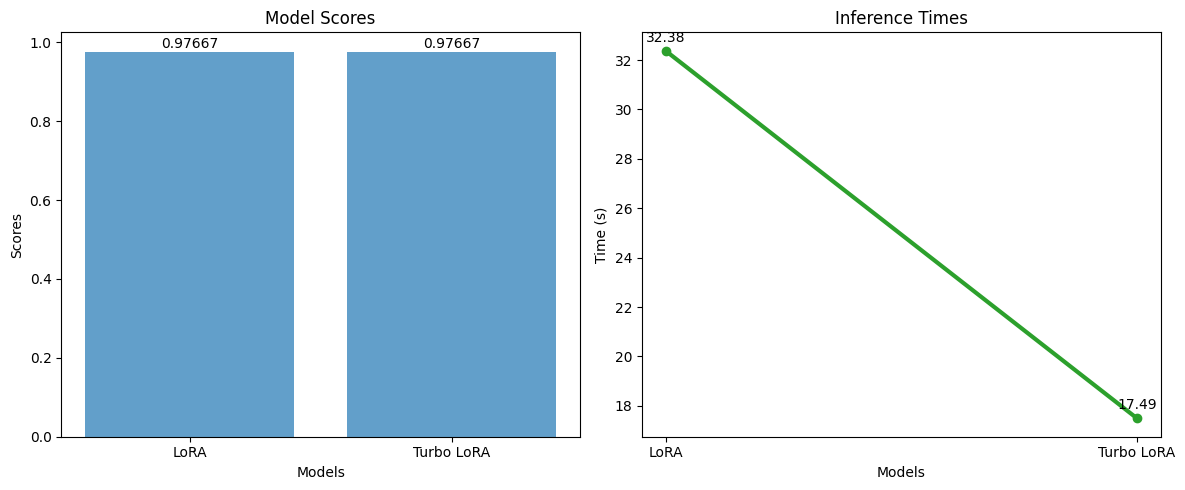

In [ ]:
scores = [jaccard_score_lora, jaccard_score_turbo_lora]
times = [total_time_lora, total_time_turbo_lora]
models = ['LoRA', 'Turbo LoRA']

create_viz(models, scores, times)

## Turbo LoRA + FP8

Implementing FP8 quantization can reduce the memory footprint of deploying a fine-tuned SLM by 50%, leading to nearly 2x further improvements in throughput. This optimization not only improves performance but also enhances the cost-efficiency of deployments, allowing for up to 2x more simultaneous requests on the same number of GPUs.

In [ ]:
# Grab deployment
client = pb.deployments.client("llama-3-1-8b-instruct-l40s-fp8", force_bare_client=True)

# Warmup Deployment
_ = client.generate(df_sample.iloc[0]['prompt'], max_new_tokens=128, temperature=1)

In [ ]:
adapter_id = "conllpp-demo/5"

# Warmup Query For Turbo LoRA - Downloads Weights
client.generate(df_sample.iloc[0]['prompt'], adapter_id=adapter_id, max_new_tokens=128, temperature=1).generated_text

# Run inference over dataset sample
generated_completions_turbo_lora_fp8, total_time_turbo_lora_fp8 = benchmark_inference(df_sample, client, adapter_id=adapter_id)

# Generate Scores
jaccard_score_turbo_lora_fp8 = multiset_jaccard_similarity(generated_completions_turbo_lora_fp8, df_sample['completion'].tolist())

# Log Time Taken and Score
print(f"Total Time: {total_time_turbo_lora_fp8:.2f}")
print(f"Jaccard Score: {jaccard_score_turbo_lora_fp8:.5f}")

Starting request 0
Starting request 5
Starting request 10
Starting request 15
Starting request 20
Starting request 25
Starting request 30
Starting request 35
Starting request 40
Starting request 45
Starting final request!
Total Time: 13.68
Jaccard Score: 0.97667


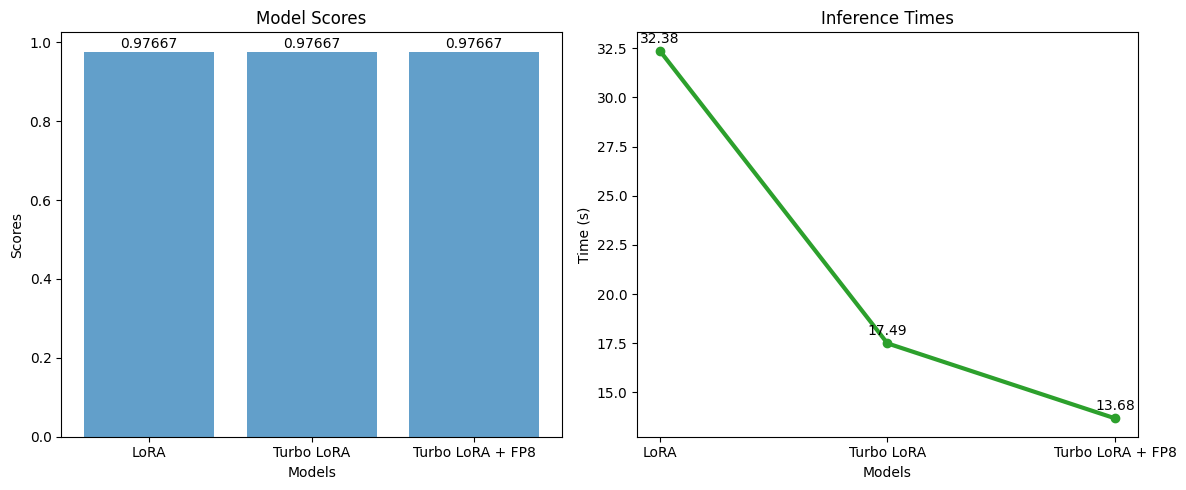

In [ ]:
scores.append(jaccard_score_turbo_lora_fp8)
times.append(total_time_turbo_lora_fp8)
models.append('Turbo LoRA + FP8')

create_viz(models, scores, times)

In [ ]:
print(f"Overall Speedup With Turbo LoRA: {times[0]/times[1]:.2f}x")
print(f"Overall Speedup With Turbo LoRA + FP8: {times[0]/times[2]:.2f}x")
print(f"Overall Change In Score: +{scores[2]-scores[0]:.5f}")

Overall Speedup With Turbo LoRA: 1.85x
Overall Speedup With Turbo LoRA + FP8: 2.37x
Overall Change In Score: +0.00000
